# Practice using clustering with baby names dataset


In [119]:
%pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [227]:
import pandas as pd
import re # regular expressions
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import OrdinalEncoder

import plotly.express as px
import seaborn as sns
from collections import Counter

In [155]:
baby = pd.read_csv("babyNamesAllStates.csv")
baby.head()

,state,sex,year,name,freq
0,AK,F,1910,Mary,14
1,AK,F,1910,Annie,12
2,AK,F,1910,Anna,10
3,AK,F,1910,Margaret,8
4,AK,M,1910,John,8


In [156]:
baby.year.max()

2019

In [157]:
baby.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6122890 entries, 0 to 6122889
Data columns (total 5 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   state   object
 1   sex     object
 2   year    int64 
 3   name    object
 4   freq    int64 
dtypes: int64(2), object(3)
memory usage: 233.6+ MB


# 2019 data


In [158]:
baby_2019 = baby[baby.year == 2019]
baby_2019.head()

,state,sex,year,name,freq
28543,AK,M,2019,Liam,52
28544,AK,M,2019,Oliver,46
28545,AK,F,2019,Emma,41
28546,AK,F,2019,Evelyn,41
28547,AK,M,2019,Henry,41


In [159]:
USA_2019 = baby_2019[['sex', 'name', 'freq']].groupby(["name", "sex"]).sum()
USA_2019.reset_index(inplace=True)
USA_2019.head()

,name,sex,freq
0,Aadam,M,6
1,Aadarsh,M,6
2,Aaden,M,43
3,Aadhav,M,6
4,Aadhvik,M,5


In [160]:
# define ordinal encoding
#encoder = OrdinalEncoder()
# transform data
#encoder.fit_transform(USA_2019.sex)
sex_dict = {'M':0, 'F':1}
USA_2019['is_female'] = [sex_dict[i] for i in USA_2019.sex]
USA_2019.head()

,name,sex,freq,is_female
0,Aadam,M,6,0
1,Aadarsh,M,6,0
2,Aaden,M,43,0
3,Aadhav,M,6,0
4,Aadhvik,M,5,0


In [161]:
USA_2019["length"] = USA_2019.name.str.len()
USA_2019.head()

,name,sex,freq,is_female,length
0,Aadam,M,6,0,5
1,Aadarsh,M,6,0,7
2,Aaden,M,43,0,5
3,Aadhav,M,6,0,6
4,Aadhvik,M,5,0,7


In [162]:
#vowel count
# source https://30-seconds-of-python-code.readthedocs.io/snippets/count_vowels/

def count_vowels(word):
    """Includes aeiou and y. Since y is often used as a vowel in names"""
    return len(re.findall(r'[aeiouy]', word, re.IGNORECASE))

USA_2019["vowel_count"] = USA_2019.name.apply(count_vowels)
USA_2019.head(-5)

,name,sex,freq,is_female,length,vowel_count
0,Aadam,M,6,0,5,3
1,Aadarsh,M,6,0,7,3
2,Aaden,M,43,0,5,3
3,Aadhav,M,6,0,6,3
4,Aadhvik,M,5,0,7,3
...,...,...,...,...,...,...
9522,Zyir,M,17,0,4,2
9523,Zyla,F,81,1,4,2
9524,Zylah,F,21,1,5,2
9525,Zylan,M,5,0,5,2


In [163]:
# Create the cluster model
X = USA_2019[["is_female", "length", "vowel_count"]]
kMeans = MiniBatchKMeans(random_state=42, batch_size = 1024)
kMeans.fit(X)
cluster_centers = kMeans.predict(X)
#USA_2019_trans = kMeans.transform(X)

In [164]:
USA_2019["cluster_centers"] = cluster_centers

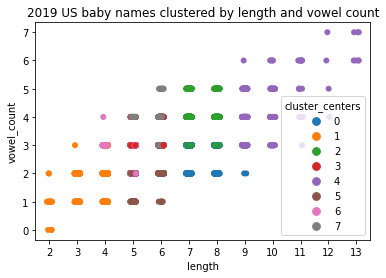

In [224]:
# The primary parameters used in clustering (aside from sex)
sns.stripplot(data=USA_2019, y="vowel_count", x="length", hue="cluster_centers", jitter=True, size=6, 
              ).set_title("2019 US baby names clustered by length and vowel count");

<AxesSubplot:xlabel='vowel_count', ylabel='freq'>

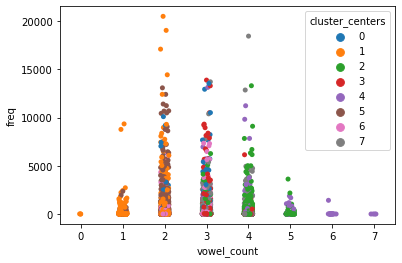

In [166]:
sns.stripplot(data=USA_2019, y="freq", x="vowel_count", hue="cluster_centers", jitter=True)

In [180]:
freq_cutoff = 9000
fig = px.strip(data_frame=USA_2019[USA_2019.freq>freq_cutoff], x="cluster_centers", y="freq", color="is_female",
                hover_data=["name", "freq"], stripmode="overlay")

fig.show()

In [220]:
# Make a fancy plot with labels.
# Change the cut off to see more names
freq_cutoff = 9500
fig = px.scatter(data_frame=USA_2019[USA_2019.freq>freq_cutoff], x="cluster_centers", y="freq", color="sex",
                hover_data=["name", "freq"], opacity=0.0, text="name", template="ygridoff",
                    labels={        
            "cluster_centers": "Cluster id",
            "freq": "Frequency in 2019"
            })

#fig.update_traces(textposition='top center')

fig.update_layout(
    height=600,
    title_text='2019 most popular names, by clusters'
)
# font changing color https://stackoverflow.com/questions/60001622/how-to-change-color-of-text-in-plotly-scatter-and-different-marker
fig.for_each_trace(lambda t: t.update(textfont_color=t.marker.color, textfont_size=12))


fig.show()

<AxesSubplot:xlabel='is_female', ylabel='freq'>

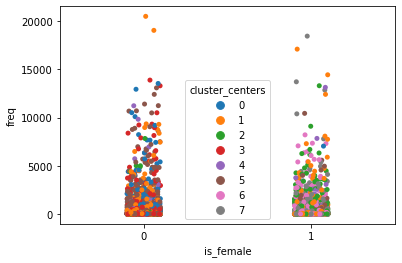

In [168]:
sns.stripplot(data=USA_2019, y="freq", x="is_female", hue="cluster_centers", jitter=True)

# Word similarity
using counter, make a hashmap to add counts of each letter to dataframe for 2019 data

In [277]:
#using counter, make a hashmap to add counts of each letter to dataframe for 2019 data
# Do a mini-toy test to make sure this will work
bobby = Counter("Bobby".lower())
billy = Counter("Billy".lower())
df = pd.DataFrame(["Billy", "Bobby"], columns=["name"])
series = df.name.apply(str.lower).apply(Counter)
pd.merge(pd.DataFrame(dict(series)).T, df, how="outer", right_index=True, left_index=True)

,b,i,l,y,o,name
0,1.0,1.0,2.0,1.0,NaN,Billy
1,3.0,NaN,NaN,1.0,1.0,Bobby


In [283]:
# Try the same thing on the 2019 data
series = USA_2019.name.apply(str.lower).apply(Counter)
USA_2019_lcount = pd.merge(pd.DataFrame(dict(series)).T, USA_2019, how="outer", right_index=True, left_index=True)
USA_2019_lcount.drop(["cluster_centers"], axis="columns")
USA_2019_lcount.head()

,a,d,m,r,s,h,e,n,v,i,...,p,w,q,name,sex,freq,is_female,length,vowel_count,cluster_centers
0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Aadam,M,6,0,5,3,3
1,3.0,1.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Aadarsh,M,6,0,7,3,0
2,2.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,Aaden,M,43,0,5,3,3
3,3.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,Aadhav,M,6,0,6,3,3
4,2.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,Aadhvik,M,5,0,7,3,0


In [367]:
#Add column for first letter
#encode letters from 0-25
#  ord() converts to ascii character
#  Then multiply to make it stronger effect?
USA_2019_lcount['first'] = ord(USA_2019_lcount.name[0][0].lower())-97

USA_2019_lcount.head()

,a,d,m,r,s,h,e,n,v,i,...,w,q,name,sex,freq,is_female,length,vowel_count,cluster_centers,first
0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,Aadam,M,6,0,5,3,364,0
1,3.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,Aadarsh,M,6,0,7,3,449,0
2,2.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,Aaden,M,43,0,5,3,294,0
3,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,Aadhav,M,6,0,6,3,364,0
4,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,Aadhvik,M,5,0,7,3,35,0


In [368]:
# Fill na's with 0
USA_2019_lcount = USA_2019_lcount.fillna(0)
USA_2019_lcount.head()

,a,d,m,r,s,h,e,n,v,i,...,w,q,name,sex,freq,is_female,length,vowel_count,cluster_centers,first
0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,Aadam,M,6,0,5,3,364,0
1,3.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,Aadarsh,M,6,0,7,3,449,0
2,2.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,Aaden,M,43,0,5,3,294,0
3,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,Aadhav,M,6,0,6,3,364,0
4,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,Aadhvik,M,5,0,7,3,35,0


In [375]:
drop_cols=["name", "sex", "freq", "length", "vowel_count", "cluster_centers", "is_female"]
X = USA_2019_lcount.drop(columns=drop_cols, axis="columns")
kMeans = MiniBatchKMeans(n_clusters = 1000, random_state=42, batch_size = 1024)
kMeans.fit(X)
cluster_centers = kMeans.predict(X)

In [376]:
USA_2019_lcount["cluster_centers"] = cluster_centers

In [377]:
USA_2019_lcount

,a,d,m,r,s,h,e,n,v,i,...,w,q,name,sex,freq,is_female,length,vowel_count,cluster_centers,first
0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,Aadam,M,6,0,5,3,898,0
1,3.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,Aadarsh,M,6,0,7,3,650,0
2,2.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,Aaden,M,43,0,5,3,824,0
3,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,Aadhav,M,6,0,6,3,431,0
4,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,Aadhvik,M,5,0,7,3,485,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9527,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,Zymere,M,5,0,6,3,143,0
9528,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,Zymir,M,55,0,5,2,266,0
9529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,Zyon,M,171,0,4,2,577,0
9530,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,Zyra,F,16,1,4,2,944,0


In [378]:
name_to_check = "Jeffrey"
sex = "M"

# Get and display name
columns_to_show=["name", 'sex', 'freq']
cluster = USA_2019_lcount[(USA_2019_lcount.name == name_to_check) & (USA_2019_lcount.sex == sex)].cluster_centers
if len(cluster) == 0:
    display("That name simply does not exist")
else:
    display(USA_2019_lcount[USA_2019_lcount.cluster_centers == int(cluster)][columns_to_show])

,name,sex,freq
2783,Effie,F,8
4469,Jeff,M,28
4470,Jefferson,M,276
4471,Jeffery,M,201
4472,Jeffrey,M,848
4473,Jeffry,M,7


# All years
Coming "soon"... 